In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing, linear_model 
from matplotlib import pyplot as plt
import time

# Load training times
train_epl00 = pd.read_csv('./data/EPL00_01.csv', encoding="ISO-8859-1")
train_epl01 = pd.read_csv('./data/EPL01_02.csv', encoding="ISO-8859-1")
train_epl02 = pd.read_csv('./data/EPL02_03.csv', encoding="ISO-8859-1")

# Load testing files
test_epl03 = pd.read_csv('./data/EPL03_04.csv', encoding="ISO-8859-1")
test_epl04 = pd.read_csv('./data/EPL04_05.csv', encoding="ISO-8859-1")

# Concat all training and test files into one structure
df_train = pd.concat((train_epl00, train_epl01, train_epl02), axis=0, ignore_index=True)
df_test = pd.concat((test_epl03, test_epl04), axis=0, ignore_index=True)

In [55]:
# Number of records in training set
num_train = df_train.shape[0]
print(str(num_train) + " records read from multiple training files")

# Number of records in test set
num_test = df_test.shape[0]
print(str(num_test) + " records read from multiple test files")

1140 records read from multiple training files
760 records read from multiple test files


In [180]:
# Calculate points from FTR (Full time Result)
def points(set_type):
    set_type['Result'] = np.NaN
    
    for index, item in set_type['FTR'].iteritems():
        if (item == 'H'):
            set_type.set_value(index, 'Result', 3.0)
        elif (item == 'A'):
            set_type.set_value(index, 'Result', 0.0)
        else:
            set_type.set_value(index, 'Result', 1.0)

points(df_train)    

# Calculate goal difference
def goal_diff(set_type):
    set_type['Goal_diff'] = 0.0
    home_g = set_type.FTHG
    away_g = set_type.FTAG
    set_type['Goal_diff'] = home_g - away_g
    
        
goal_diff(df_train)

arsenal_str = 'Arsenal'        
arsenal = df_train[df_train['HomeTeam'] == arsenal_str][['Result', 'Goal_diff']]   

# Normalize the result mod 38 since there are 38 matches in a season
# arsenal.Result = [float(i)/sum(arsenal.Result) for i in arsenal.Result]
arsenal.Result = preprocessing.scale(arsenal.Result)
arsenal.Goal_diff = preprocessing.scale(arsenal.Goal_diff)


C:\Users\oakejp12\AppData\Local\Continuum\Miniconda3\envs\csc322\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Coefficients: 
 [  1.41932208e-16   1.00000000e+00]


ValueError: x and y must be the same size

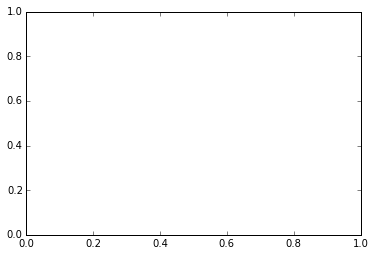

In [181]:

# Split the data into training/testing sets
ars_X_train = np.array(arsenal[:38])
ars_X_test = np.array(arsenal[38:])


# Split the targets into training/testing sets
ars_y_train = np.array(arsenal.Goal_diff[:38])
ars_y_test = np.array(arsenal.Goal_diff[38:])


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(ars_X_train, ars_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
# print("Residual sum of squares: %.2f" )

plt.scatter(ars_X_test, ars_y_test, color='black')
plt.plot(ars_X_test, regr.predict(ars_X_test), color='blue')